In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

In [4]:
emotion=pd.read_csv('dataset\combined_emotion.csv')
emotion.head()

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


In [5]:
## Load the datatset
df=pd.read_csv('dataset\combined_emotion.csv')

# Extract text and labels
texts = df["sentence"].values
labels = df["emotion"].values

# Encode labels into integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Convert labels to numerical values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
# Tokenization
max_words = 10000  # Vocabulary size
max_len = 100      # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [6]:
from gensim.models import Word2Vec

# Load Gensim Word2Vec model
w2v_model = Word2Vec.load("D:/Projects/Emotion Detection/model/word2vec_model.bin")

# Create an embedding matrix for Keras Embedding layer
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((max_words, embedding_dim))

word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < max_words:  # Limit to max_words
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

# Now use this matrix in the embedding layer
embedding_layer = Embedding(input_dim=max_words, 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=max_len, 
                            trainable=False)  # Set trainable=False to keep Word2Vec embeddings fixed


d:\Projects\Emotion Detection\emotion_detect_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, Embedding, LayerNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
import numpy as np

# Use the same pre-trained Word2Vec embedding matrix
embedding_layer = Embedding(input_dim=max_words, 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=max_len, 
                            trainable=False)  # Keep Word2Vec embeddings fixed

# Define CNN Model for Emotion Detection
model = Sequential([
    embedding_layer,                      # Pre-trained Word2Vec embeddings
    Conv1D(filters=256, kernel_size=5, activation='relu'),  # Feature extraction
    LayerNormalization(),
    Dropout(0.3),
    GlobalMaxPooling1D(),                # Select the most important features
    Dense(128),
    LeakyReLU(),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')  # Output layer
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model with EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping]
)  # Training on Google Colab


Epoch 1/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 569s 54ms/step - accuracy: 0.7900 - loss: 0.6196 - val_accuracy: 0.9142 - val_loss: 0.1924
Epoch 2/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 569s 54ms/step - accuracy: 0.9108 - loss: 0.2185 - val_accuracy: 0.9206 - val_loss: 0.1708
Epoch 3/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 433s 41ms/step - accuracy: 0.9190 - loss: 0.1846 - val_accuracy: 0.9192 - val_loss: 0.1875
Epoch 4/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 543s 51ms/step - accuracy: 0.9226 - loss: 0.1695 - val_accuracy: 0.9093 - val_loss: 0.2536
Epoch 5/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 452s 43ms/step - accuracy: 0.9248 - loss: 0.1604 - val_accuracy: 0.8852 - val_loss: 0.3778


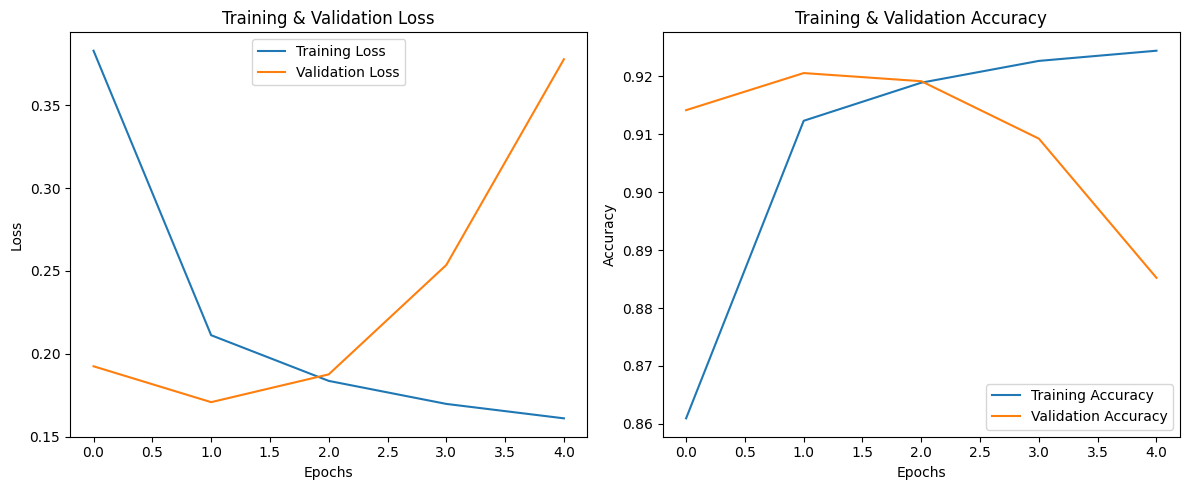

In [8]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history object
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy (if available)
if 'accuracy' in history_dict:  # Use 'acc' for older TensorFlow versions
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)

# Decode predicted labels
predicted_emotions = label_encoder.inverse_transform(predicted_labels)


2643/2643 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9204 - loss: 0.1703
Test Accuracy: 0.9206
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step


In [10]:
def predict_emotion(sentence):
    # Load tokenizer and label encoder
    #with open("tokenizer.pkl", "rb") as file:
        #tokenizer = pickle.load(file)

    #with open("label_encoder.pkl", "rb") as file:
        #label_encoder = pickle.load(file)

    # Preprocess input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Load model
    #model = tf.keras.models.load_model("emotion_lstm_model.h5")

    # Make prediction
    prediction = model.predict(padded_sequence)
    predicted_label = np.argmax(prediction)
    predicted_emotion = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_emotion




In [11]:
# Example usage
example_sentences =  [
        "The weather is wonderful today!",
        "I am feeling really sad and lonely.",
        "What an exciting game we had last night!",
        "I can't believe how much I've learned this year!",
        "I was so angry during the meeting today.",
        "I can't believe how everything turned out today, it's a bit overwhelming.",
        "I guess I'm doing okay, but it's not as good as I hoped.",
        "That was such a fantastic presentation, even though I made some mistakes.",
        "I'm so glad I made it through the day, but I'm exhausted!",
        "I can't stop thinking about how much better things could have been.",
        "It was a long day, but I had a lot of fun!",
        "My cat died today."
    ]

for i in example_sentences:
    print(i,":",predict_emotion(i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
The weather is wonderful today! : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
I am feeling really sad and lonely. : sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
What an exciting game we had last night! : fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
I can't believe how much I've learned this year! : anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
I was so angry during the meeting today. : anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
I can't believe how everything turned out today, it's a bit overwhelming. : fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
I guess I'm doing okay, but it's not as good as I hoped. : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
That was such a fantastic presentation, even though I made some mistakes. : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
I'm so glad I made it through the day, but I'm exhausted! : sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
I can't stop thinking about how much better things could have been. : joy
1/1 ━━━━━━━━━━━━━━━━━━━━

2643/2643 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step


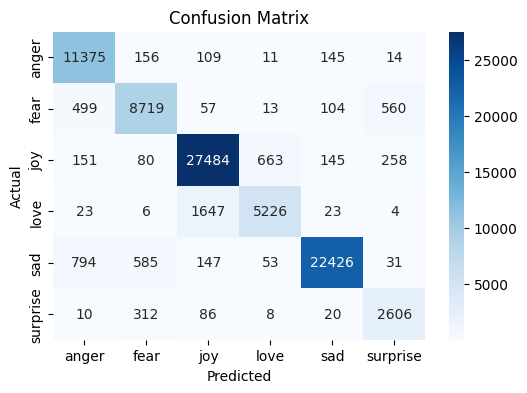

              precision    recall  f1-score   support

       anger       0.89      0.96      0.92     11810
        fear       0.88      0.88      0.88      9952
         joy       0.93      0.95      0.94     28781
        love       0.87      0.75      0.81      6929
         sad       0.98      0.93      0.96     24036
     suprise       0.75      0.86      0.80      3042

    accuracy                           0.92     84550
   macro avg       0.88      0.89      0.89     84550
weighted avg       0.92      0.92      0.92     84550



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred = model.predict(X_test_pad)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.shape[1] > 1 else (y_pred > 0.5).astype("int32")

# Now compute the confusion matrix
cm = confusion_matrix(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_classes))
emotion_labels = ['anger', 'fear', 'joy', 'love', 'sad', 'surprise']

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=emotion_labels,yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_classes)))


In [15]:

import os
model_path = "../model"
os.makedirs(model_path, exist_ok=True)

model.save(os.path.join(model_path,'CNN.keras'))